# Setup

In [1]:
# Import packages
import os
import re
import sys
import json
import string
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt

tf.__version__ # 2.x

'2.3.0'

In [2]:
# Globals
BUFFER_SIZE = 5000
BUFFER_BATCH_SIZE = 64
VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 512
EMBEDDING_DIM = 128

# Setup input pipelines

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]
print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [4]:
# View some examples from train
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
# View some examples from test
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BUFFER_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'This is unlike any other movie, the closest thing I can compare it to is a Woody Allen film... But where as Woody Allen is constantly fathoming human foibles Bret Carr appears to be trying to figure out a way to get to grips with that one crippling insecurity that tends to define us for better or worse. In the Case of Lou, it is the root cause of his stuttering, which can be traced back to a singular child hood trauma that is revealed through flash backs.<br /><br />There are so many strangely neurotic people in the world and I believe they all deserve a chance for redemption, although diversity of human character is after all what makes the world such an intriguing place, so maybe we shouldn\'t fix our neurosis anymore than we should fix our noses or Breasts.<br /><br />This is an indie film shot on a long shoestring, but the production values are tremendous as is the scope of the film. I feel like its a quirky Gem for the self-help market. I really look forward to seeing 

# Data processing

In [8]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML).
# We will need to create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

In [9]:
encoder = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = MAX_SEQUENCE_LENGTH
)

# Adapt to train text
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
for element in train_dataset:
    print(element[0][0])
    break

tf.Tensor(b'You know how Star Trek fans flocked to all the Star Trek movies, even the really bad ones? Why? To see their heroes in action one more time. That\'s the way I feel about Doc Savage. I am a major fanatic for the character, and the prospect of seeing Doc and his crew in an adventure was overwhelming. And the first 20 minutes of the film only heightened that feeling of anticipation. Then they decided to crib elements from a number of Doc adventures and throw them into this one movie, resulting in a somewhat disjointed film. There\'s a lot of promise in here, diluted by a number of unfortunate choices (the music, the "camp" elements, etc.) But the spirit of Doc is there, and that\'s what those of us familiar with Doc and his crew respond to. So, in my long-winded way, what I\'m trying to say is that this is not a bad movie: it\'s just not as good as it should have been. And anyone who is a fan of Superman, James Bond, Indiana Jones, Buckaroo Banzai, and many other characters ou

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the data.
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

# Modelling

In [12]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.Dropout(0.3)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

# We create a model object
model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [14]:
# Train and validate model on sub-sample from test dataset
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data = test_dataset,
    validation_steps = 10,
    callbacks = callbacks
)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5294 - accuracy: 0.6888 - val_loss: 0.4016 - val_accuracy: 0.8078
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.2795 - accuracy: 0.8882 - val_loss: 0.2887 - val_accuracy: 0.8719
Epoch 3/10
391/391 [==============================] - 6s 17ms/step - loss: 0.2017 - accuracy: 0.9212 - val_loss: 0.2817 - val_accuracy: 0.8922
Epoch 4/10
391/391 [==============================] - 6s 16ms/step - loss: 0.1426 - accuracy: 0.9488 - val_loss: 0.3624 - val_accuracy: 0.8672
Epoch 5/10
391/391 [==============================] - 6s 16ms/step - loss: 0.0994 - accuracy: 0.9629 - val_loss: 0.4034 - val_accuracy: 0.8719
Epoch 6/10
391/391 [==============================] - 6s 17ms/step - loss: 0.0762 - accuracy: 0.9716 - val_loss: 0.5450 - val_accuracy: 0.8594


In [15]:
# Evaluate model performance on test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print("Test loss;", test_loss)
print("Test accuracy:", test_acc)

391/391 [==============================] - 3s 7ms/step - loss: 0.4501 - accuracy: 0.8720
Test loss; 0.4500563144683838
Test accuracy: 0.8719599843025208


# Visualize model performance

In [16]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

(0.0, 0.5684802774339914)

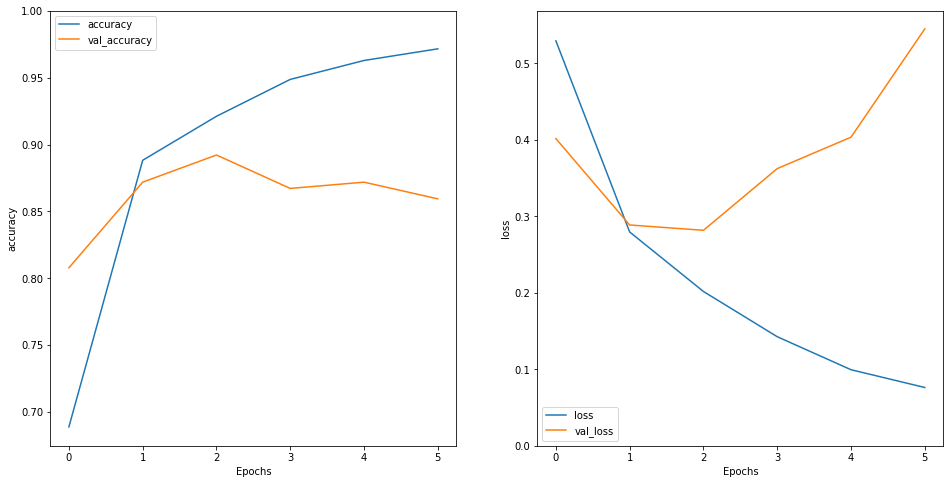

In [17]:
# Create a figure
plt.figure(figsize=(16,8))

# Plot accuracy graph
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None,1)

# Plot loss graph
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)